In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, decomposition, model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sagemaker
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput 


%matplotlib inline

In [2]:
data_dir = 'input_data'
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
data_prefix = 'santander_project/data'
seed=0
n_components=200

# Reading in training dataset
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), index_col='ID')

## PCA Reduction
Here i choose to explore various kernels for a standard PCA approach, before ultimately selecting one for use. I also separately conducting a sparse PCA model using SageMaker. The computational cost of the sparse pca is such that i simply saved the output for potential use in modeling.

### Exploring Kernel-based PCA

First, comparing performance of various PCA kernels

In [3]:
# Scaling features to means
std_scale = preprocessing.StandardScaler().fit(train_df.iloc[:, 1:])
train_df_scaled = std_scale.transform(train_df.iloc[:, 1:])

# Applying Box-Cox transform to target
train_df['target'] = stats.boxcox(train_df['target'])[0]

In [ ]:
# Looping through kernels and plotting component correlations to target
kernels=['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

fig = plt.figure(figsize=(20, 5))

kernel_outputs = {}

for i, kernel in enumerate(kernels):
    kpca_sm = decomposition.KernelPCA(n_components=n_components, kernel=kernel)
    kpca_sm.fit(train_df_scaled)
    train_df_kpca = pd.concat([train_df['target'], pd.DataFrame(kpca_sm.transform(train_df_scaled), columns=['c{}'.format(num+1) for num in range(n_components)], index=train_df.index)], axis=1)
    correlation_kpca = train_df_kpca.corr(method='spearman')['target'][1:]
    
    #Saving results in dictionary for post-evaluation use
    kernel_outputs[kernel] = {}
    kernel_outputs[kernel]['coeffs'] = correlation_kpca
    kernel_outputs[kernel]['data']= train_df_kpca
    kernel_outputs[kernel]['transformer'] = kpca_sm
    
    #Plotting results
    ax = fig.add_subplot(1, 5, i+1)
    ax.scatter(range(len(correlation_kpca)), np.sort(correlation_kpca))
    ax.set_title('{} Kernel'.format(kernel))
    ax.set_xlabel('Components')
    ax.set_ylabel('Correlation')
    ax.set_ylim(-.3, .3)

fig.suptitle('Kernel-Based Comparison of Component/Target Correlations', fontsize=20, y=1.01)
fig.tight_layout(pad=3.0)

The polynomial kernel appears to have the highest magnitude of correlations to the target. Next examining the relationships between components and the target for each kernel

In [ ]:
sample = 5
fig, axs = plt.subplots(ncols=5, nrows=sample, figsize=(30, 15))

for iy,kernel in enumerate(kernels):
    for ix, component in enumerate(kernel_outputs[kernel]['data'].iloc[:, 1:].sample(sample, axis=1)):
        sns.regplot(kernel_outputs[kernel]['data'][component], train_df['target'], ax=axs[ix, iy]).set_title('{} and Target ({} Kernel)'.format(component, kernel), fontsize=18)
    
fig.suptitle('Relationship Between PCA Components and Target Using Various Kernels', fontsize=50, y=1.05)
fig.tight_layout(pad=3.0)

### Conducting Selected PCA Reduction and Saving Output

PCA using a cosine model appeared to result in the clearest relationship to the target. Using a gridsearch to optimize the paramaters, assuming this will be ultimately fitted to a gradient boosting regression model. Selecting components meeting correlation threshold and saving to a dataframe for regression modeling.

In [4]:
selected_kpca = decomposition.KernelPCA(kernel='linear')
RFRegressor = RandomForestRegressor()

X = train_df_scaled
y = train_df['target'] 

pipe = Pipeline(steps=[('pca', selected_kpca), ('rf_regressor', RFRegressor)])

param_grid = {
    'pca__n_components' : [20, 50, 100, 200]}

pca_search = GridSearchCV(pipe, param_grid, n_jobs=-1)
pca_search.fit(X, y)

pca_search.best_params_

{'pca__n_components': 20}

In [5]:
optimized_kpca = pca_search.best_estimator_[0]

In [6]:
train_df_optimized = pd.concat([train_df['target'], pd.DataFrame(optimized_kpca.transform(train_df_scaled), columns=['c{}'.format(num+1) for num in range(pca_search.best_params_['pca__n_components'])], index=train_df.index)], axis=1)

Examining explained variance of components

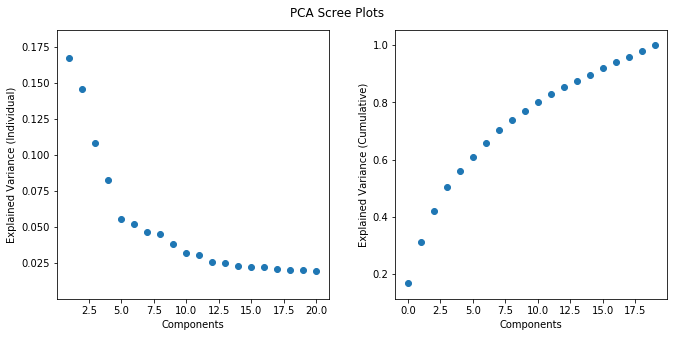

In [8]:
kpca_transform = train_df_optimized.iloc[:, 1:]
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = pd.Series((explained_variance / np.sum(explained_variance)), index=train_df_optimized.columns).sort_values(ascending=False) 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.scatter(range(len(explained_variance_ratio)), np.sort(explained_variance_ratio)[::-1])
ax1.set_ylabel('Explained Variance (Individual)')
ax1.set_xlabel('Components')
ax2.scatter(range(len(explained_variance_ratio)), cumulative_explained_variance_ratio.values)
ax2.set_ylabel('Explained Variance (Cumulative)')
ax2.set_xlabel('Components')

fig.suptitle('PCA Scree Plots', fontsize=12)
fig.tight_layout(pad=3.0)

Filtering components based on proportion of explained variance

In [9]:
pca_threshold = .8
best_components = cumulative_explained_variance_ratio[cumulative_explained_variance_ratio <= pca_threshold]
pca_cols = [['target'] + list(best_components.index)][0]
train_df_final_pca = train_df_optimized.loc[:, pca_cols]

Saving dataframe of best components to local drive

In [10]:
train_df_final_pca.to_csv(os.path.join(data_dir, 'train_pca.csv'), header=False, index=False)

Transforming test data using fitted standard scaler and PCA model

In [11]:
chunksize = 5000 

if os.path.exists(os.path.join(data_dir, 'test_pca.csv')):
    os.remove(os.path.join(data_dir, 'test_pca.csv'))

for chunk in pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col='ID', chunksize=chunksize):
        scaled_chunk = std_scale.transform(chunk.values)
        transformed_chunk = optimized_kpca.transform(scaled_chunk)
        transformed_chunk_df = pd.DataFrame(transformed_chunk, columns=['c{}'.format(num+1) for num in range(pca_search.best_params_['pca__n_components'])], index=chunk.index).loc[:, list(best_components.index)]
        transformed_chunk_df.to_csv(os.path.join(data_dir, 'test_pca.csv'), header=False, index=False, mode='a')

Uploading PCA output to s3

In [12]:
sagemaker_session.upload_data(path=os.path.join(data_dir, 'train_pca.csv'), bucket=bucket, key_prefix=data_prefix)
sagemaker_session.upload_data(path=os.path.join(data_dir, 'test_pca.csv'), bucket=bucket, key_prefix=data_prefix)

's3://sagemaker-us-east-2-278383315865/santander_project/data/test_pca.csv'

### Conducting Sparse PCA Reduction and Saving Output

Evaluating the performance of sparse PCA on the dataset. Because of the computational cost, i am executing the transformation using the SageMaker API and saving the output for future use.

In [ ]:
train_path = 's3://{}/{}/train.csv'.format(bucket, data_prefix)
test_path = 's3://{}/{}/test.csv'.format(bucket, data_prefix)

sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.c4.xlarge',
                                     instance_count=1)

#Running imputation processing script
sklearn_processor.run(code='processing_scripts/sparse_PCA.py',
                      inputs=[ProcessingInput(
                        source=train_path,
                        destination='/opt/ml/processing/input/train'), ProcessingInput(
                        source=test_path,
                        destination='/opt/ml/processing/input/test'),],
                      outputs=[ProcessingOutput(output_name='train_pca',
                                                source='/opt/ml/processing/train'),
                               ProcessingOutput(output_name='test_pca',
                                                source='/opt/ml/processing/test')]
                     )


preprocessing_job_description = sklearn_processor.jobs[-1].describe()

preprocessing_job_description

output_config = preprocessing_job_description['ProcessingOutputConfig']

for output in output_config['Outputs']:
    if output['OutputName'] == 'train_pca':
        preprocessed_training_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'test_pca':
        preprocessed_test_data = output['S3Output']['S3Uri']


Saving sparse PCA output to local drive

In [ ]:
pd.read_csv(preprocessed_training_data + '/train_sparse_pca.csv', index_col='ID').to_csv(os.path.join(data_dir, 'train_sparse_pca.csv'), header=False, index=False)
pd.read_csv(preprocessed_test_data + '/test_sparse_pca.csv', index_col='ID').to_csv(os.path.join(data_dir, 'test_sparse_pca.csv'), header=False, index=False)

Uploading sparse PCA output to s3

In [ ]:
sagemaker_session.upload_data(path=os.path.join(data_dir, 'train_sparse_pca.csv'), bucket=bucket, key_prefix=data_prefix)
sagemaker_session.upload_data(path=os.path.join(data_dir, 'test_sparse_pca.csv'), bucket=bucket, key_prefix=data_prefix)